In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|default_exp train

# train

> Training images

In [ ]:
import ultralytics

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
Setup complete ✅ (22 CPUs, 15.3 GB RAM, 35.6/250.9 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image
from minai import *
import fastcore.all as fc
from fastcore.utils import L
from pilus_project.core import *
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchvision.transforms import v2

In [ ]:
set_seed(42)

In [ ]:
path = fc.Path.home()/'data/pili/training_data'
path.ls()

(#18) [Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/0N01002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.csv'),Path('/hom

In [ ]:
ims = L(path.glob('*.nd2'))
ims

(#9) [Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_data/0N01002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.nd2')]

In [ ]:
paths = [(im, im.with_suffix('.csv')) for im in ims]
paths

[(Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),
  Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv')),
 (Path('/home/kappa/data/pili/training_data/0N01002.nd2'),
  Path('/home/kappa/data/pili/training_data/0N01002.csv')),
 (Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),
  Path('/home/kappa/data/pili/training_data/7.1- 003.csv')),
 (Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),
  Path('/home/kappa/data/pili/training_data/0.1%.004.csv')),
 (Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),
  Path('/home/kappa/data/pili/training_data/1hr01002.csv')),
 (Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),
  Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv')),
 (Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),
  Path('/home/kappa/data/pili/training_data/4hrs incu004.csv')),
 (Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),
  Path('/home/kappa/data/pili/training_data/WT-A86C

In [ ]:
csvs = L(path.glob('*.csv'))
csvs

(#9) [Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/7.1- 003.csv'),Path('/home/kappa/data/pili/training_data/0.1%.004.csv')]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trn_path, val_path = train_test_split(paths, test_size=0.2, random_state=42)
val_path

[(Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),
  Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv')),
 (Path('/home/kappa/data/pili/training_data/0N01002.nd2'),
  Path('/home/kappa/data/pili/training_data/0N01002.csv'))]

In [ ]:
class PiliDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_files = list(Path(image_dir).glob('*.nd2'))
        self.transform = transform
        
    def __len__(self): return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = get_im(img_path)
        label_path = img_path.with_suffix('.csv')
        corners = calc_corners(str(label_path))
        
        if self.transform:
            img = self.transform(img)
            
        return img, corners

In [ ]:
list(zip(*val_path))

[(Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),
  Path('/home/kappa/data/pili/training_data/0N01002.nd2')),
 (Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),
  Path('/home/kappa/data/pili/training_data/0N01002.csv'))]

TODO: Normalize with pretrained data statistics

In [ ]:
tfm = v2.Compose([
    get_im,
    v2.ToImage(),
    v2.ConvertImageDtype(torch.float32),
    v2.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0]==1 else x),
    v2.Normalize(mean=[0.0048, 0.0048, 0.0048], std=[0.0138, 0.0138, 0.0138]), # statistics from data
])

In [ ]:
def process_img(im): return tfm(get_im(im))

In [ ]:
trn_ds = TfmDataset(*zip(*trn_path), tfm_x=tfm, tfm_y=calc_corners)
val_ds = TfmDataset(*zip(*val_path), tfm_x=tfm, tfm_y=calc_corners)
x, y = next(iter(trn_ds))
x.shape, y[:5]

(torch.Size([3, 1952, 1952]),
 tensor([[4.0000, 0.2166, 0.8646, 0.1645, 0.8972, 0.1545, 0.8812, 0.2066, 0.8486],
         [4.0000, 0.2334, 0.6836, 0.1811, 0.6986, 0.1753, 0.6781, 0.2275, 0.6632],
         [4.0000, 0.2122, 0.4038, 0.1546, 0.3905, 0.1585, 0.3732, 0.2161, 0.3865],
         [4.0000, 0.2814, 0.2086, 0.2660, 0.1467, 0.2855, 0.1418, 0.3009, 0.2038],
         [4.0000, 0.3904, 0.3313, 0.3666, 0.2960, 0.3813, 0.2861, 0.4051, 0.3214]], dtype=torch.float64))

In [ ]:
x[0].shape

torch.Size([1952, 1952])

In [ ]:
x.mean(), x.std()

(tensor(0.0597), tensor(1.4359))

In [ ]:
# Getting the statistics of data
# imgs = [x for x,y in trn_ds]
# timgs = torch.stack(imgs)
# timgs.shape
# timgs.mean((0,2,3)), timgs.std((0,2,3))

In [ ]:
@fc.delegates(plt.Axes.imshow)
def imshow_with_boxes(im, boxes, figsize=(8,8), **kwargs):
    import matplotlib.patches as patches
    colors = {
        1: 'red',    # GREEN YELLOW
        2: 'blue',   # TURQUOISE
        3: 'green',  # THISTLE 
        4: 'yellow', # COrAL
        5: 'purple', # WHITE
        6: 'orange'  # MAGENTA
    }
    class_names = {
        1: 'Type 1 - Both poles free',
        2: 'Type 2 - One pole occluded',
        3: 'Type 3 - Both poles occluded',
        4: 'Type 4 - Super bright cell',
        5: 'Type 5 - Very dim cell',
        6: 'Type 6 - Partial cell'
    }

    if im.shape[0]==3: im=im[0]
    height, width = im.shape[:2]
    fig, ax = plt.subplots(figsize=figsize)
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    plt.axis('off')

    unique_classes = boxes[:,0].unique().int().tolist()
    legend_elements = [patches.Patch(facecolor='none',
                                   edgecolor=colors[class_idx],
                                   label=class_names[class_idx])
                      for class_idx in unique_classes]

    for box in boxes:
        class_idx = box[0].item()
        corners = [[box[1].item() * width, box[2].item() * height],
                  [box[3].item() * width, box[4].item() * height],
                  [box[5].item() * width, box[6].item() * height],
                  [box[7].item() * width, box[8].item() * height]]

        color = colors.get(box[0].item(), 'white')
        polygon = patches.Polygon(corners, fill=False,
                                edgecolor=color,
                                linewidth=2)
        ax.add_patch(polygon)

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

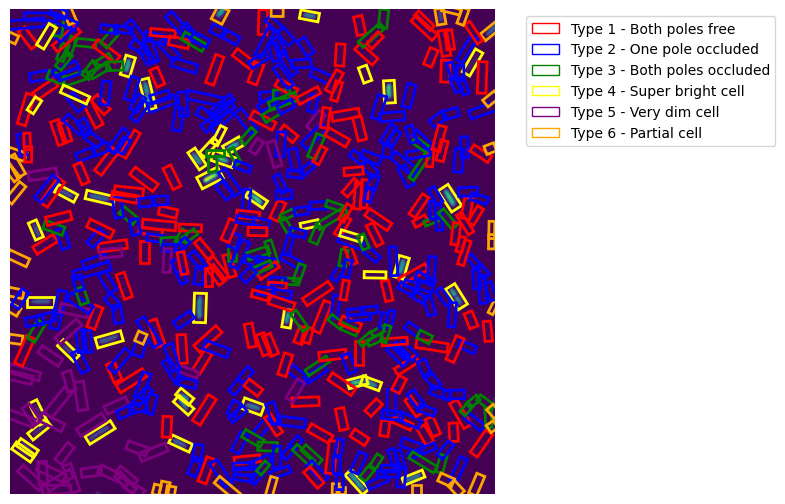

In [ ]:
imshow_with_boxes(x, y)

In [ ]:
bs=2

In [ ]:
def collate_fn(batch):
    """Custom collate function to handle variable number of boxes"""
    imgs = torch.stack([item[0] for item in batch]) 
    boxes = [item[1] for item in batch]  
    return imgs, boxes

trn_dl, val_dl = dls = get_dls(trn_ds, val_ds, bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(trn_dl))
xb.shape,yb[0]

(torch.Size([2, 3, 1952, 1952]),
 tensor([[ 4.0000,  0.4952,  0.1168,  ...,  0.0789,  0.5141,  0.1168],
         [ 6.0000,  0.4814,  0.0082,  ..., -0.0070,  0.4969,  0.0168],
         [ 1.0000,  0.5268,  0.0588,  ...,  0.0091,  0.5402,  0.0439],
         ...,
         [ 1.0000,  0.7748,  0.4930,  ...,  0.4457,  0.7915,  0.4990],
         [ 1.0000,  0.7768,  0.4339,  ...,  0.4303,  0.7722,  0.4168],
         [ 2.0000,  0.7423,  0.4943,  ...,  0.4381,  0.7589,  0.5003]], dtype=torch.float64))

In [ ]:
import sys, gc, traceback, math, typing, random, numpy as np
from collections.abc import Mapping
from copy import copy
from itertools import zip_longest
from functools import partial, wraps
from operator import attrgetter, itemgetter

import matplotlib.pyplot as plt
import fastcore.all as fc
from fastprogress import progress_bar, master_bar

import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import default_collate

from torcheval.metrics import Mean

In [ ]:
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(dls.train))
xb.shape,yb[0]

(torch.Size([2, 3, 1952, 1952]),
 tensor([[4.0000, 0.9067, 0.2497,  ..., 0.2230, 0.9110, 0.2337],
         [4.0000, 0.4559, 0.3301,  ..., 0.2846, 0.4734, 0.3230],
         [4.0000, 0.5351, 0.3602,  ..., 0.3862, 0.5183, 0.3547],
         ...,
         [2.0000, 0.5490, 0.3630,  ..., 0.3476, 0.5499, 0.3500],
         [3.0000, 0.5057, 0.3783,  ..., 0.3380, 0.5198, 0.3793],
         [1.0000, 0.5676, 0.2528,  ..., 0.2573, 0.5592, 0.2413]], dtype=torch.float64))

In [ ]:
class YOLOWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = YOLO("yolo11n-obb.pt").model
        # Keep the original loss
        self.loss_fn = self.model.loss
        
    def forward(self, x):
        return self.model(x)
    
    def train(self, mode=True):
        """Override train method"""
        super().train(mode)
        if hasattr(self.model, 'training'):
            self.model.training = mode
        return self

In [ ]:
model = YOLOWrapper()
model

YOLOWrapper(
  (model): OBBModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running

In [ ]:
from shapely.geometry import Polygon
 
def create_polygon_from_coordinates(coords):
    """Creating a Polygon object from the coordinates of the rotated bounding box."""
    return Polygon([(coords[i], coords[i+1]) for i in range(0, len(coords), 2)])
 
def calculate_iou_rotated_from_coords(box1_coords, box2_coords):
    """Calculation of IoU for two rotated bounding boxes with their corner coordinates."""
    poly1 = create_polygon_from_coordinates(box1_coords)
    poly2 = create_polygon_from_coordinates(box2_coords)
   
    intersection = poly1.intersection(poly2).area
    union = poly1.area + poly2.area - intersection
    iou = intersection / union if union > 0 else 0.0
    return iou
 
class RotatedBoundingBoxLoss(nn.Module):
    def __init__(self, num_classes=5, iou_threshold=0.5):
        super().__init__()
        self.iou_threshold = iou_threshold
        self.num_classes = num_classes
        self.class_loss = nn.CrossEntropyLoss()  # Classification loss
        self.regression_loss = nn.SmoothL1Loss()  # Bounding box regression loss
 
    def forward(self, preds, targets):
        """
        preds: Tensor of shape (N, num_classes + 9) -> (class_logits, x1, y1, ..., x4, y4, confidence)
        targets: Tensor of shape (M, 9) -> (class_label, x1, y1, ..., x4, y4)
        """
 
        total_class_loss = 0
        total_regression_loss = 0
        total_iou_loss = 0
        matched_count = 0
       
        pred_logits, pred_boxes = preds[:, :self.num_classes], preds[:, self.num_classes:-1]  # Separate logits and coordinates
        gt_classes, gt_boxes = targets[:, 0], targets[:, 1:]  # Separate class labels and coordinates
 
        # Ensure proper data types
        gt_classes = gt_classes.long()  # Convert target class labels to LongTensor
 
        # Compute pairwise IoU between all predicted and GT boxes
        iou_matrix = torch.zeros(len(preds), len(targets), dtype=torch.float64)
 
        for i, pred_box in enumerate(pred_boxes):
            for j, gt_box in enumerate(gt_boxes):
                iou_matrix[i, j] = calculate_iou_rotated_from_coords(pred_box.tolist(), gt_box.tolist())
 
        # Match predictions to GT using max IoU (Greedy Matching)
        for pred_idx, gt_idx in enumerate(torch.argmax(iou_matrix, dim=1)):
            max_iou = iou_matrix[pred_idx, gt_idx]
 
            if max_iou >= self.iou_threshold:
                # **Fix: Ensure pred_classes is a proper tensor of shape [1, num_classes]**
                class_loss = self.class_loss(pred_logits[pred_idx].unsqueeze(0).float(), gt_classes[gt_idx].unsqueeze(0))
 
                # Bounding box regression loss
                reg_loss = self.regression_loss(pred_boxes[pred_idx], gt_boxes[gt_idx])
 
                # IoU loss (1 - IoU to minimize)
                iou_loss = 1 - max_iou
 
                total_class_loss += class_loss
                total_regression_loss += reg_loss
                total_iou_loss += iou_loss
                matched_count += 1
 
        # Normalize by the number of matched pairs
        if matched_count > 0:
            total_class_loss /= matched_count
            total_regression_loss /= matched_count
            total_iou_loss /= matched_count
 
        return total_class_loss + total_regression_loss + total_iou_loss
 
 
loss_fn = RotatedBoundingBoxLoss(num_classes=6)  # num_classes

In [ ]:
cbs = [
    TrainCB(), # Handles the core steps in the training loop. Can be left out if using TrainLearner
    DeviceCB(), # Handles making sure data and model are on the right device
#     MetricsCB(accuracy=MulticlassAccuracy()), # Keep track of any relevant metrics
    ProgressCB(), # Displays metrics and loss during training, optionally plot=True for a pretty graph
]

# The learner takes a model, dataloaders and loss function, plus some optional extras like a list of callbacks
learn = Learner(model, dls, loss_fn, lr=0.1, cbs=cbs)
learn

<minai.core.Learner>

TypeError: tuple indices must be integers or slices, not tuple

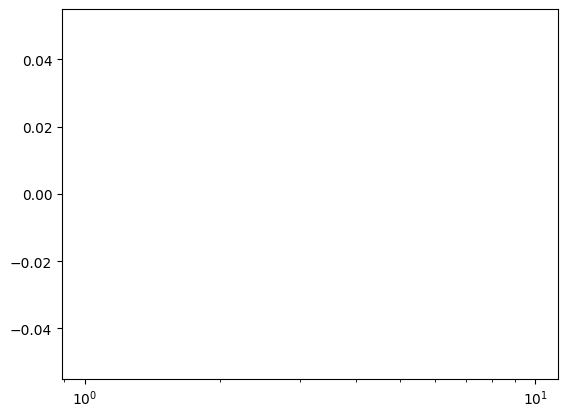

In [ ]:
learn.lr_find()